# LVM Data Simulator tutorial: installation, configuration and basic steps

**This is a tutorial on how to install, configure and test the very basic usage of the LVM Data Simulator.**
- More details on the setup of LVM instrumentation and on the structure of the outputs of the simulator are given in [tutorial #2](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial2.ipynb)
- More realistic and useful simulations are considered in [tutorial #3](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial3.ipynb) - please go there if you have already installed and configured the package and want to learn how to simulate the source field in more details.


_Last update: 2022/05/31_

## Installation and setup

### Installing the package

The package can be found on github at this link: https://github.com/sdss/lvmdatasimulator

First clone the package with:

```git clone --recursive https://github.com/sdss/lvmdatasimulator --branch main```
    
then move into the package directory and install it with ``python -m pip install -e .``. Pip should automatically install all the dependencies needed for the simulator to work (if not, let us know!)

### Downloading libraries

Once the package is installed, you have to download three files that are temporarily stored in an FTP server at Universidad de Chile.

To download them you should run the following commands and move the files in the ```lvmdatasimulator/data``` directory:

```wget ftp@ftp.das.uchile.cl:/pub/enrico/LVM_cloudy_models.fits```

```wget ftp@ftp.das.uchile.cl:/pub/enrico/pollux_resampled_v0.fits```

At this point, everything should be ready to go. We just want to highlight that this is still a work-in-progress, and in the future how the simulator is called could change significantly. The goal is to write a main.py script able to read a configuration file.

**N.B.: This notebook should run just fine once you download and install the package. However, we suggest to move it to a different, empty directory, where it will be possible to save all the files produced during the test, or to change the work directory as follows:**

In [ ]:
# Please do not run this cell, unless you want to change the work directory
import os
os.chdir('/directory/where/I/want/to/save/all/files/')  # change to the correct path before running

## Part 1: Simulating the target field

The first step to perform the simulations is to create a field to be observed. Once the field is created, all its components can be saved to fits files and used again in future runs.

We first need to import all the necessary modules needed for the simulations:

In [ ]:
import astropy.units as u
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

Then, we need to setup the LVM field object:

In [ ]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, spaxel=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_spaxel=u.arcsec, name='LVM_test')

This line initializes the LVMField object. The needed inputs are:
- ra, dec: coordinates of the field to be observed. Used to build the WCS object
- size: size of the field to simulate
- spaxel: size of the spaxel
- unit_ra, unit_dec: unit used for the coordinates of the field, defaults to degrees
- unit size: unit of the size argument. defaults to arcmin
- unit_spaxel: unit of the spaxels, defaults to arcsec
- name: name of the field. It will be used to define the names of the output files.

The object is still empty, we need to generate the targets of the simulations. There are two types iof targets that can be simulated: **stars** and **nebulae**.

**Stars** are simulated by searching the GAIA catalog for stars brighter than a user defined limit. To each star we associate a spectrum, based on the estimated temperature of the object. All spectra are recovered from the pollux spectral library. **The library is missing spectra with temperature between 8000 and 12000 degrees. Stellar spectra should only be used for signal-to-noise ratio estimates, not to recover physical quantities**.

The stellar component is created as following:

In [ ]:
my_lvmfield.generate_gaia_stars(gmag_limit=18)

Once created, the star list is automatically saved to file, and it can be used to re-run the simulation without having to query GAIA again. The default position of this file is the current working directory, but it can be saved in another position by defining the *directory* argument. To read the saved file:

In [ ]:
my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz')

The nebular component, on the other hand, contains a wide variety of different types of sources that can be created. While there are some core quantities shared among most types of sources, many need some type-specific keywords to be defined. For a complete view of the inputs needed for each kind of nebula, we refer to the code documentation and to the [tutorial #3](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial3.ipynb), where the modelling of the ISM is presented in more details.

The nebular component should be passed to the field object as a list of dictionaries. Each dictionary represent a single nebula. Here we simulate only DIG component for simplicity:

In [ ]:
my_nebulae = [{"type": 'DIG', 'max_brightness': 1e-17, 'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc},
              ]

To include the nebulae in the LVMField object we can use:

In [ ]:
my_lvmfield.add_nebulae(my_nebulae, save_nebulae="testneb_tutorial1.fits")

The nebulae will be saved to file, so that they can be reused for other simulations without having to generate them. To read the nebulae from file:

In [ ]:
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial1.fits")

 ## Part 2: Setting up the simulator


At this point the Field is ready to be observed. We are still missing, however, the complete instrument setup. The instrument is composed by a **telescope**, a **spectrograph** and a **fiber bundle**. To create the elements we just need to generate the objects as follows:

In [ ]:
tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='central', nrings=4, angle=0, custom_fibers=None)

So far, we support a single telescope object LVM160() and a single spectrograph configuration LinearSpectrograph(). The latter, in particular, is a spectrograph with a 3650-9800 A wavelength range, and a constant 0.5 A dispersion.

The fiber bundle, on the other hand, is already pretty configurable. For now we will use a standard configuration. In [tutorial #2](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial2.ipynb) we describe how to create and simulate different fiber configurations.

In [ ]:
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='full_5.png')


The last step before running the simulator is to define the properties of the observations by initializing the **Observation** object. Also this object is configurable and all the different options will be described in [tutorial #2](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial2.ipynb).


In [ ]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[24*900])


## Part 3: Running the simulator

Now we are ready to perform the simulation. First we initialize the simulator, giving it as an input all the things we already initialized:

In [ ]:
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Them we can perform the simulations and save the outputs:

In [ ]:
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570], unit_range=u.AA)

Also a detailed description of the outputs will be provided in [tutorial #2](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial2.ipynb).

In [16]:
run_simulator_1d(parameters)

[INFO]: Start generating 1 nebulae
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #0: use default 'cloudy_id=Cloud_366'
100% (1 of 1) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03
[INFO]: Generated ISM saved to ./testneb_tutorial1.fits
[INFO]: ISM content saved to testneb_tutorial1.fits
[INFO]: 139 Gaia stars in the field
[INFO]: 101 stars are fainter than 18 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
 50% (19 of 38) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00

INFO: Query finished. [astroquery.utils.tap.core]


100% (38 of 38) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 38 synthetic spectra.
[INFO]: Saving star list to: ./LVM_test_starlist.fits.gz
[WARNING]: The file ././LVM_test_starlist.fits.gz already exist and it will be overwritten


[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_test_6550_6570_input_map.fits
[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 331 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
100% (1 of 1) |##########################| Elapsed Time: 0:01:03 Time:  0:01:03
[INFO]: Resampling spe

Elapsed time: 95.9


Multiple images can be produced at the same time, by providing a list of wavelength ranges to be integrated.

## Part 4: Simulator as ETC: very simplified run

This simulator can be easily used to estimate the required LVM exposures for the objects of your interest. The complex cases accounting for filling factor of the nebulae, differences of the line ratios, kinematics, overlapping etc. require individual consideration.
**Here we provide very simplified ETC calculator** which just allows one to estimate the required exposure time in the lines of interest, for the object that has:
- uniform brightness distribution
- constant emission line ratios (defined by one of the pre-computed Cloudy models)
- or/and constant level and shape of the continuum
- the star with particular properties also can be part of the object under evaluation. Nebular component, continuum from the object and the stellar spectrum will be combined together by the simulator in a single fiber, for which we will run the calculations.

Note also that the resulting S/N ratio is the values measured per spectral pixel (0.5A) in the output spectra at particular wavelength. Thus, this simplified ETC doesn't integrate the flux in emission lines, but rather estimate S/N for the peaks. We can modify this behaviour later.
Also note that all calculations are performed assuming the single exposure.

In [1]:
from lvmdatasimulator.run import run_lvm_etc

Define parameters of your nebula. The only required parameter is 'max_brightness' (in erg/s/cm\^2/arcsec^2).

Also you may define parameters of the star if you want to put it in the fiber. It should be a dictionary with the keywords that is used by LVMField.generate_single_stars.
See [tutorial #3](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial3.ipynb) if you want to learm how to specify the spectral properties (emission and continuum) of the nebula, and how to properly set up the properties of the star

In [4]:
neb_params = {'max_brightness': 1e-16, 'cloudy_id': 'Shell_3'}
star_params = None


The dictionary below (``params``) is the main input for the ETC. It joins together the parameters of the nebula and the star, and also can contain parameters defining the observations (see [tutorial 2](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial2.ipynb)). Note that ``exptimes`` is not used as it is hardcoded in the ETC. No specific parameters for observations are required by default, but you may want to adjust, e.g., airmass, moon distance etc.

Another two parameters required for ETC:
- ``check_lines`` - list of the lines (wavelength in A, float) for which ETC will check the dependence of the S/N on the exposure time.
- ``desired_snr`` - if provided, then ETC will print (and return) the required exposures to reach the target S/N at the respective wavelength.


[INFO]: Start simulations in the mode of exposure time calculator for 1 nebula 
[INFO]: Start generating 1 nebulae
100% (1 of 1) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
[INFO]: Using only the central fiber.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 1 fibers.
[INFO]: Start extracting nebular spectra
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./outputs/LVM_Field_ETC_linear_central_input.fits saved.
[INFO]: Uncalibrated outputs
[INFO]:

To reach S/N=30 in line = 6563.0±1.0A we need 2181s of single exposure
To reach S/N=10 in line = 6717.0±1.0A we need 3074s of single exposure
To reach S/N=15 in line = 4861.0±1.0A we need 2347s of single exposure


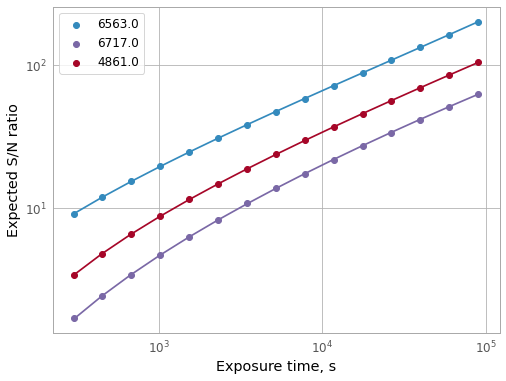

Elapsed time: 7.7s


[2181, 3074, 2347]

In [5]:
params = {'nebula': neb_params,
          'star': star_params,
          }


run_lvm_etc(params, check_lines=[6563., 6717., 4861.], desired_snr=[30, 10, 15])